In [ ]:
%run ../talktools.py

# MCMC for Bayesian Inference

<font color="grey">AY128/256 (UC Berkeley 2018$-$2024)</font>

As we just saw in the Bayes intro, there are some cases where we can get a closed/analytic form of the posterior, but many examples we cannot get a closed form. Instead we need to sample the posterior numerically.

- Markov Chain Monte Carlo: Stochastic methods useful for sampling from the target posterior distribution

- Can be implmented where conjugacy does not hold and grid appoximations fail

- Can work in high dimensions

- Iterative: we must decide when convergance has happened

- Some Popular methods: [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), [NUTS (No U-Turns)](https://arxiv.org/abs/1111.4246), [Hessian-Hamiltonian](https://people.csail.mit.edu/tzumao/h2mc/)...

<u>Idea</u>: Suppose that sampling from the posterior $p(\theta|$**X**) is hard but that we can somehow generate a [Markov chain](http://setosa.io/ev/markov-chains/) $\{\theta(t), t \in T\}$ with stationary distribution $p(\theta|$**X**)

- We want to set up a chain that will take us to the stationary distribution $\pi = p(\theta|$**X**)

- Once we find such a chain, we will start from some initial guess $\theta^0$ and tun the chain for a large number of steps until it converged to $\pi$

- After convergence we run a bunch more steps of the chain and use those as draws from $p(\theta|$**X**).

- All MCMC methods are based on this idea. The differences are in how the Markov chain transitions are created.

<img src="data/ma.png">

<img src="data/ma1.png">

We can visualize different approaches to sampling [here](https://chi-feng.github.io/mcmc-demo/app.html#AdaptiveMH,standard).

## Useful, pedagogical paper on MCMC in Astro:
### [Hogg & Foreman-Mackey 2018](https://ui.adsabs.harvard.edu/abs/2018ApJS..236...11H/abstract)

## MCMC with PyMC
https://www.pymc.io

<img width="20%" src="https://raw.githubusercontent.com/pymc-devs/brand/main/pymc/pymc_logos/PyMC_banner.svg">

https://www.pymc.io/projects/examples/

```
conda create -c conda-forge -n pymc_env "pymc>=5"
conda activate pymc_env
```

or (I believe this will also work if you don't use conda as your python distribution)

```
pip install pymc
pip install arviv
```

PyMC is the most widely used Markov chain Monte Carlo module in Python

- It allows straightforward coding of probability models and posterior sampling of those models with standard (optimized) MCMC algorithms
- Large and complicated (hierarchical) models can be easily coded in PyMC
- Convergence diagnostics and automatic tuning are provided 
- Users can input custom probability distributions and fitting algorithms 
- Great documentation

Let's look at the Presidental approval rating again:

Text(0.5, 1.0, 'Posterior distribution: Biden Approval Jan 26-29, 2024')

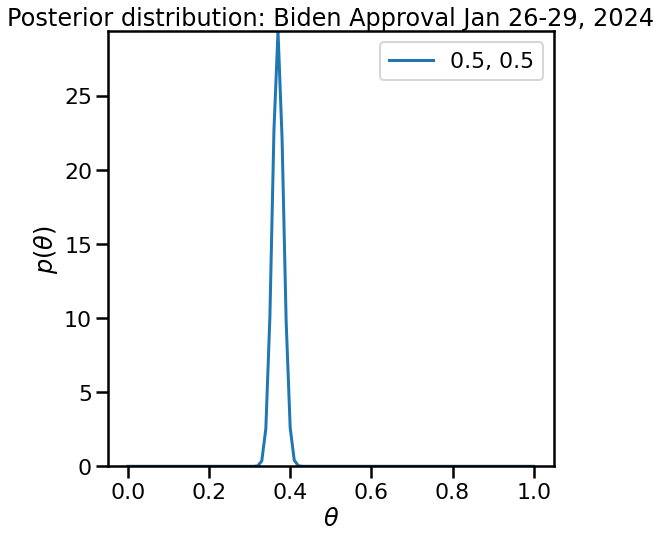

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")

a = 466
n = 1260

alpha = 0.5
beta = 0.5

x_theta = np.linspace(0, 1, 101)
fig, ax = plt.subplots(figsize=(8,8))

p_theta = stats.beta(alpha + a, beta + n - a).pdf(x_theta)
ax.plot(x_theta, p_theta, linewidth=3.,label=f"{alpha}, {beta}")
    
ax.legend()
ax.set_ylim([0, max(p_theta)])
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$p(\theta)$")
ax.set_title("Posterior distribution: Biden Approval Jan 26-29, 2024")

In [3]:
import pymc as pm
import arviz as az
from arviz import plot_trace 

In [4]:
with pm.Model() as model:
    theta = pm.Beta('theta', alpha, beta)
    X = pm.Binomial('X', n, theta, observed=a)

In [82]:
pm.Binomial?

In [5]:
with model:
    trace = pm.sample(3000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 19 seconds.


In [84]:
trace['theta']

array([0.35156766, 0.35889183, 0.35459699, ..., 0.37381109, 0.37381109,
       0.3640456 ])

In [85]:
traceplot?

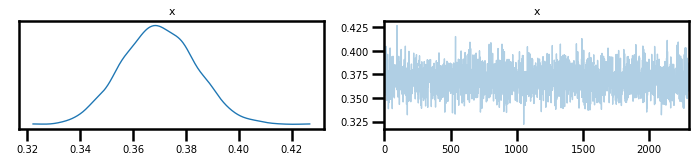

In [86]:
with model:
    traceplot(trace['theta'][500:][::5])

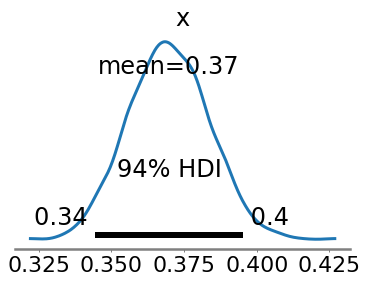

In [87]:
with model:
    az.plot_posterior(trace['theta'][500:][::5])

Note: we started sampling after a burn-in period of a thousand steps. We also "pruned" the result by taking only every 5th step (helps insure some level of independence between samples). 

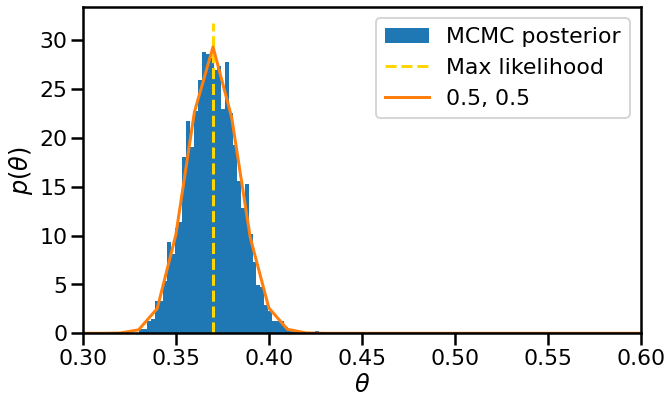

In [88]:
plt.figure(figsize=(10,6))
xx = plt.hist(trace['theta'][500:][::5], bins=50, label='MCMC posterior', density=True)
plt.vlines(x=a / n, ymin=0, ymax=max(xx[0])+3, linestyle='--', label="Max likelihood", color="gold")
plt.plot(x_theta, p_theta, linewidth=3.,label=f"{alpha}, {beta}")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend()
_ = plt.xlim(0.3,0.6)

So our MCMC results agree with the (closed-form) solution for this simple case.

Once we have samples from the posterior we can do cool things:

Suppose we have B samples $\theta_1$...$\theta_B$ from the posterior $p(\theta|$**X**):

1) **Posterior mean**: 
   
The exact equation $E[\theta|$**X**] = $\int \theta p(\theta|$**X**)$d\theta$

Using the sample $E[\theta|$**X**] $\approx \frac{1}{B} \sum_{b=1}^B \theta_b$

In [89]:
trace['theta'][1000:][::5].sum()/len(trace['theta'][1000:][::5])

0.3697057041548417

2) **Marginalization**: 
   
The exact equation $p(\theta_1|$**X**) = $\int p(\theta_1,\theta_2,..\theta_p|$**X**)$d\theta_2\theta_3...\theta_p$

Using the sample $p(\theta_1|$**X**) $\sim \theta_{1,1} ... \theta_{1,B}$

*That is, record the parameter of interest $\theta_1$ from each sample.*

3) **Prediction**: 
   
The exact equation $p(\tilde{X}|$**X**) = $\int p(\tilde{X}|\theta) p(\theta|$**X**)$d\theta$

Using the sample $p(\tilde{X}|$**X**) $\sim \tilde{x_1} | \theta_{1} ... \tilde{x_B} | \theta_{B}$

*That is, take each sample of $\theta$ and determine a value for $x$.*